<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:13:39] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


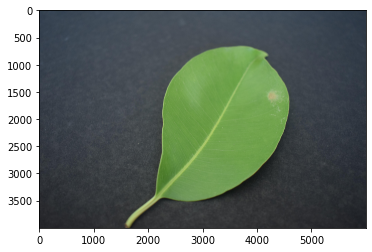

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

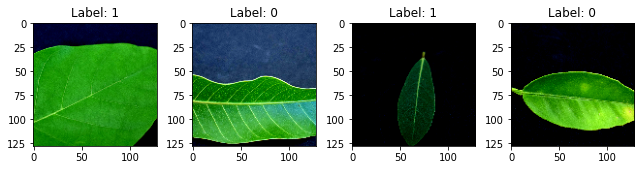

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:13:45] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:13:47] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2641599043358913 samples/sec                   batch loss = 2.146986484527588 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2305282974224223 samples/sec                   batch loss = 0.9457346200942993 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.269001477293244 samples/sec                   batch loss = 1.1506867408752441 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2763529989230602 samples/sec                   batch loss = 0.5879946351051331 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2711355480370843 samples/sec                   batch loss = 0.38796332478523254 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2588409988062286 samples/sec                   batch loss = 0.48909541964530945 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.264062752520163 samples/sec                   batch loss = 1.1347383260726929 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2726105824585592 samples/sec                   batch loss = 0.6982134580612183 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.264385697108274 samples/sec                   batch loss = 0.7558134198188782 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2600573278521507 samples/sec                   batch loss = 0.6949496269226074 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.264780027452844 samples/sec                   batch loss = 0.4726092517375946 | accuracy = 0.5727272727272728


Epoch[1] Batch[60] Speed: 1.2627237708208066 samples/sec                   batch loss = 1.2826801538467407 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.266365164378528 samples/sec                   batch loss = 0.580956757068634 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2648641296931569 samples/sec                   batch loss = 0.4913783073425293 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2644993861864209 samples/sec                   batch loss = 0.4080040156841278 | accuracy = 0.5933333333333334


Epoch[1] Batch[80] Speed: 1.2641760025004396 samples/sec                   batch loss = 0.33961817622184753 | accuracy = 0.6


Epoch[1] Batch[85] Speed: 1.2658403235837645 samples/sec                   batch loss = 0.5132330656051636 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.275909694712667 samples/sec                   batch loss = 0.7244338393211365 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2763569800582155 samples/sec                   batch loss = 0.7837069630622864 | accuracy = 0.5894736842105263


Epoch[1] Batch[100] Speed: 1.2716436811901406 samples/sec                   batch loss = 0.5836475491523743 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.266309152979377 samples/sec                   batch loss = 0.8284122943878174 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.266179848656589 samples/sec                   batch loss = 0.5637909770011902 | accuracy = 0.6


Epoch[1] Batch[115] Speed: 1.2648501118763877 samples/sec                   batch loss = 1.1165481805801392 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2713640324477447 samples/sec                   batch loss = 0.8842767477035522 | accuracy = 0.6083333333333333


Epoch[1] Batch[125] Speed: 1.2664294019800642 samples/sec                   batch loss = 0.7403165698051453 | accuracy = 0.606


Epoch[1] Batch[130] Speed: 1.2682450849615752 samples/sec                   batch loss = 0.5026252269744873 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.272483366041886 samples/sec                   batch loss = 0.5581432580947876 | accuracy = 0.6074074074074074


Epoch[1] Batch[140] Speed: 1.2678939115123165 samples/sec                   batch loss = 0.2581699788570404 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2725098110631308 samples/sec                   batch loss = 0.5433057546615601 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.2722294918669965 samples/sec                   batch loss = 0.7807021737098694 | accuracy = 0.6183333333333333


Epoch[1] Batch[155] Speed: 1.2727112732683854 samples/sec                   batch loss = 0.4795547425746918 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2716098508361806 samples/sec                   batch loss = 1.1622650623321533 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.2749298311273565 samples/sec                   batch loss = 2.059490203857422 | accuracy = 0.6196969696969697


Epoch[1] Batch[170] Speed: 1.2630854936080882 samples/sec                   batch loss = 1.377540111541748 | accuracy = 0.6191176470588236


Epoch[1] Batch[175] Speed: 1.2620912304858698 samples/sec                   batch loss = 0.6995790600776672 | accuracy = 0.6214285714285714


Epoch[1] Batch[180] Speed: 1.2787330911314825 samples/sec                   batch loss = 0.6550445556640625 | accuracy = 0.6236111111111111


Epoch[1] Batch[185] Speed: 1.2694798559211502 samples/sec                   batch loss = 0.4534655809402466 | accuracy = 0.6229729729729729


Epoch[1] Batch[190] Speed: 1.2694494063923072 samples/sec                   batch loss = 0.5641599297523499 | accuracy = 0.6276315789473684


Epoch[1] Batch[195] Speed: 1.2721010012595737 samples/sec                   batch loss = 0.3381533622741699 | accuracy = 0.6282051282051282


Epoch[1] Batch[200] Speed: 1.2676256785907225 samples/sec                   batch loss = 0.6672080159187317 | accuracy = 0.62875


Epoch[1] Batch[205] Speed: 1.2719313601075088 samples/sec                   batch loss = 0.4244864583015442 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.2771843323922114 samples/sec                   batch loss = 0.8985695838928223 | accuracy = 0.6297619047619047


Epoch[1] Batch[215] Speed: 1.2741264899615132 samples/sec                   batch loss = 0.8636705875396729 | accuracy = 0.6348837209302326


Epoch[1] Batch[220] Speed: 1.2765394592235466 samples/sec                   batch loss = 0.731773853302002 | accuracy = 0.6363636363636364


Epoch[1] Batch[225] Speed: 1.2820421200089682 samples/sec                   batch loss = 0.599900484085083 | accuracy = 0.6355555555555555


Epoch[1] Batch[230] Speed: 1.284049686120977 samples/sec                   batch loss = 1.7936840057373047 | accuracy = 0.6369565217391304


Epoch[1] Batch[235] Speed: 1.2729867821862448 samples/sec                   batch loss = 0.7675406336784363 | accuracy = 0.6404255319148936


Epoch[1] Batch[240] Speed: 1.2770075008096795 samples/sec                   batch loss = 0.6535985469818115 | accuracy = 0.640625


Epoch[1] Batch[245] Speed: 1.2740873025245163 samples/sec                   batch loss = 0.8264210224151611 | accuracy = 0.6438775510204081


Epoch[1] Batch[250] Speed: 1.2818206523960616 samples/sec                   batch loss = 0.7447266578674316 | accuracy = 0.645


Epoch[1] Batch[255] Speed: 1.2748910786509597 samples/sec                   batch loss = 0.45369967818260193 | accuracy = 0.6460784313725491


Epoch[1] Batch[260] Speed: 1.2720061933780864 samples/sec                   batch loss = 0.3955291211605072 | accuracy = 0.6461538461538462


Epoch[1] Batch[265] Speed: 1.2740847868701621 samples/sec                   batch loss = 0.8527635931968689 | accuracy = 0.6424528301886793


Epoch[1] Batch[270] Speed: 1.2683393329892574 samples/sec                   batch loss = 0.36468300223350525 | accuracy = 0.6462962962962963


Epoch[1] Batch[275] Speed: 1.2668681507542363 samples/sec                   batch loss = 0.37832069396972656 | accuracy = 0.6472727272727272


Epoch[1] Batch[280] Speed: 1.2586688321163557 samples/sec                   batch loss = 0.4752678871154785 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2617118585625453 samples/sec                   batch loss = 0.5197674036026001 | accuracy = 0.6456140350877193


Epoch[1] Batch[290] Speed: 1.2763255200577257 samples/sec                   batch loss = 0.6185373663902283 | accuracy = 0.646551724137931


Epoch[1] Batch[295] Speed: 1.2753667344821293 samples/sec                   batch loss = 0.5204266309738159 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.2732213436110527 samples/sec                   batch loss = 0.42084720730781555 | accuracy = 0.6483333333333333


Epoch[1] Batch[305] Speed: 1.272309666949154 samples/sec                   batch loss = 0.6368114352226257 | accuracy = 0.6475409836065574


Epoch[1] Batch[310] Speed: 1.2691127339151846 samples/sec                   batch loss = 0.9916802644729614 | accuracy = 0.6451612903225806


Epoch[1] Batch[315] Speed: 1.273341556022019 samples/sec                   batch loss = 0.5782134532928467 | accuracy = 0.6468253968253969


Epoch[1] Batch[320] Speed: 1.2768634664132608 samples/sec                   batch loss = 0.3271569311618805 | accuracy = 0.6484375


Epoch[1] Batch[325] Speed: 1.276185425369634 samples/sec                   batch loss = 0.5777366757392883 | accuracy = 0.6484615384615384


Epoch[1] Batch[330] Speed: 1.27052524641337 samples/sec                   batch loss = 0.4438338875770569 | accuracy = 0.65


Epoch[1] Batch[335] Speed: 1.2659483519039083 samples/sec                   batch loss = 0.5213407874107361 | accuracy = 0.6522388059701493


Epoch[1] Batch[340] Speed: 1.2712326342439462 samples/sec                   batch loss = 0.3922331929206848 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2744362038834671 samples/sec                   batch loss = 0.4465261697769165 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.271553952771288 samples/sec                   batch loss = 0.7121913433074951 | accuracy = 0.6564285714285715


Epoch[1] Batch[355] Speed: 1.270635230670681 samples/sec                   batch loss = 0.21845701336860657 | accuracy = 0.6584507042253521


Epoch[1] Batch[360] Speed: 1.2694999322770573 samples/sec                   batch loss = 0.49068692326545715 | accuracy = 0.6597222222222222


Epoch[1] Batch[365] Speed: 1.265990574879243 samples/sec                   batch loss = 0.6247814893722534 | accuracy = 0.6582191780821918


Epoch[1] Batch[370] Speed: 1.269218633012317 samples/sec                   batch loss = 0.5220858454704285 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.273386303254672 samples/sec                   batch loss = 0.4307727813720703 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.2649594972376632 samples/sec                   batch loss = 0.7554215788841248 | accuracy = 0.6605263157894737


Epoch[1] Batch[385] Speed: 1.264582021337898 samples/sec                   batch loss = 0.5033957362174988 | accuracy = 0.6597402597402597


Epoch[1] Batch[390] Speed: 1.275014804177514 samples/sec                   batch loss = 0.25152868032455444 | accuracy = 0.6621794871794872


Epoch[1] Batch[395] Speed: 1.2774247229858262 samples/sec                   batch loss = 0.28540948033332825 | accuracy = 0.6632911392405063


Epoch[1] Batch[400] Speed: 1.274363697972476 samples/sec                   batch loss = 0.23505252599716187 | accuracy = 0.665


Epoch[1] Batch[405] Speed: 1.2698833299777015 samples/sec                   batch loss = 1.224470615386963 | accuracy = 0.6666666666666666


Epoch[1] Batch[410] Speed: 1.2716761638791012 samples/sec                   batch loss = 0.2602914273738861 | accuracy = 0.6670731707317074


Epoch[1] Batch[415] Speed: 1.265346169200029 samples/sec                   batch loss = 0.2263457328081131 | accuracy = 0.6674698795180722


Epoch[1] Batch[420] Speed: 1.2701271337210058 samples/sec                   batch loss = 0.6638880372047424 | accuracy = 0.6660714285714285


Epoch[1] Batch[425] Speed: 1.2691936688045562 samples/sec                   batch loss = 1.19479238986969 | accuracy = 0.6658823529411765


Epoch[1] Batch[430] Speed: 1.2732736196918713 samples/sec                   batch loss = 0.5713300108909607 | accuracy = 0.6662790697674419


Epoch[1] Batch[435] Speed: 1.2721899386896818 samples/sec                   batch loss = 0.5420503616333008 | accuracy = 0.664367816091954


Epoch[1] Batch[440] Speed: 1.2721291666489742 samples/sec                   batch loss = 0.5477323532104492 | accuracy = 0.6642045454545454


Epoch[1] Batch[445] Speed: 1.2712583530153447 samples/sec                   batch loss = 0.5188772678375244 | accuracy = 0.6662921348314607


Epoch[1] Batch[450] Speed: 1.2757254554327624 samples/sec                   batch loss = 0.519612193107605 | accuracy = 0.6688888888888889


Epoch[1] Batch[455] Speed: 1.2712290703015403 samples/sec                   batch loss = 0.35766345262527466 | accuracy = 0.6681318681318681


Epoch[1] Batch[460] Speed: 1.2747022909091958 samples/sec                   batch loss = 0.3038444221019745 | accuracy = 0.6690217391304348


Epoch[1] Batch[465] Speed: 1.271584214217003 samples/sec                   batch loss = 0.6675620079040527 | accuracy = 0.6688172043010753


Epoch[1] Batch[470] Speed: 1.2764156318541218 samples/sec                   batch loss = 0.35738012194633484 | accuracy = 0.6691489361702128


Epoch[1] Batch[475] Speed: 1.2742647779810004 samples/sec                   batch loss = 0.2996755540370941 | accuracy = 0.6694736842105263


Epoch[1] Batch[480] Speed: 1.2746353713789278 samples/sec                   batch loss = 0.673424482345581 | accuracy = 0.66875


Epoch[1] Batch[485] Speed: 1.2744361070743473 samples/sec                   batch loss = 0.9688571691513062 | accuracy = 0.6706185567010309


Epoch[1] Batch[490] Speed: 1.2712283960444144 samples/sec                   batch loss = 0.5733062028884888 | accuracy = 0.6704081632653062


Epoch[1] Batch[495] Speed: 1.2742117430577544 samples/sec                   batch loss = 0.1887851357460022 | accuracy = 0.6717171717171717


Epoch[1] Batch[500] Speed: 1.2732746826511672 samples/sec                   batch loss = 0.532603919506073 | accuracy = 0.673


Epoch[1] Batch[505] Speed: 1.2730435790813792 samples/sec                   batch loss = 0.38237419724464417 | accuracy = 0.6732673267326733


Epoch[1] Batch[510] Speed: 1.2709522997145262 samples/sec                   batch loss = 0.20838040113449097 | accuracy = 0.6745098039215687


Epoch[1] Batch[515] Speed: 1.270186752978999 samples/sec                   batch loss = 0.9575285911560059 | accuracy = 0.6747572815533981


Epoch[1] Batch[520] Speed: 1.2746563858725795 samples/sec                   batch loss = 0.113936647772789 | accuracy = 0.675


Epoch[1] Batch[525] Speed: 1.2768385892686815 samples/sec                   batch loss = 0.8175759315490723 | accuracy = 0.6757142857142857


Epoch[1] Batch[530] Speed: 1.2714564320528698 samples/sec                   batch loss = 0.47047045826911926 | accuracy = 0.6768867924528302


Epoch[1] Batch[535] Speed: 1.2748056377642765 samples/sec                   batch loss = 3.219587802886963 | accuracy = 0.6766355140186916


Epoch[1] Batch[540] Speed: 1.275904843075307 samples/sec                   batch loss = 0.7157306671142578 | accuracy = 0.6754629629629629


Epoch[1] Batch[545] Speed: 1.2726615533796022 samples/sec                   batch loss = 0.5861642956733704 | accuracy = 0.6752293577981652


Epoch[1] Batch[550] Speed: 1.2837035560586822 samples/sec                   batch loss = 0.25731104612350464 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.2694773584284622 samples/sec                   batch loss = 0.9115127325057983 | accuracy = 0.677027027027027


Epoch[1] Batch[560] Speed: 1.2684532546933187 samples/sec                   batch loss = 0.49954915046691895 | accuracy = 0.678125


Epoch[1] Batch[565] Speed: 1.2688060814785813 samples/sec                   batch loss = 0.41520148515701294 | accuracy = 0.6783185840707965


Epoch[1] Batch[570] Speed: 1.2705436239099948 samples/sec                   batch loss = 0.3802599310874939 | accuracy = 0.6793859649122806


Epoch[1] Batch[575] Speed: 1.2713011236135554 samples/sec                   batch loss = 0.39796584844589233 | accuracy = 0.6791304347826087


Epoch[1] Batch[580] Speed: 1.2696806480593026 samples/sec                   batch loss = 0.2693026065826416 | accuracy = 0.6801724137931034


Epoch[1] Batch[585] Speed: 1.2713122020530627 samples/sec                   batch loss = 0.6927616596221924 | accuracy = 0.6803418803418804


Epoch[1] Batch[590] Speed: 1.2732395093040454 samples/sec                   batch loss = 1.3214696645736694 | accuracy = 0.6800847457627118


Epoch[1] Batch[595] Speed: 1.2708894316189312 samples/sec                   batch loss = 0.5367035269737244 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.2650937037269676 samples/sec                   batch loss = 0.26579347252845764 | accuracy = 0.68


Epoch[1] Batch[605] Speed: 1.2689189353743073 samples/sec                   batch loss = 0.48862048983573914 | accuracy = 0.6805785123966942


Epoch[1] Batch[610] Speed: 1.2672156932412206 samples/sec                   batch loss = 0.8976314663887024 | accuracy = 0.6811475409836065


Epoch[1] Batch[615] Speed: 1.2665233803305571 samples/sec                   batch loss = 0.4062831997871399 | accuracy = 0.682520325203252


Epoch[1] Batch[620] Speed: 1.2625272630361204 samples/sec                   batch loss = 0.5634967088699341 | accuracy = 0.6830645161290323


Epoch[1] Batch[625] Speed: 1.2637033254169294 samples/sec                   batch loss = 0.9965271353721619 | accuracy = 0.6828


Epoch[1] Batch[630] Speed: 1.2681240116647463 samples/sec                   batch loss = 0.7110346555709839 | accuracy = 0.6833333333333333


Epoch[1] Batch[635] Speed: 1.2635068932801157 samples/sec                   batch loss = 0.6660535931587219 | accuracy = 0.6826771653543308


Epoch[1] Batch[640] Speed: 1.2652522700454156 samples/sec                   batch loss = 0.8021522760391235 | accuracy = 0.6828125


Epoch[1] Batch[645] Speed: 1.2614746890621846 samples/sec                   batch loss = 1.021563172340393 | accuracy = 0.6821705426356589


Epoch[1] Batch[650] Speed: 1.2642905113343839 samples/sec                   batch loss = 0.31300145387649536 | accuracy = 0.683076923076923


Epoch[1] Batch[655] Speed: 1.267769648079626 samples/sec                   batch loss = 0.4617980122566223 | accuracy = 0.683969465648855


Epoch[1] Batch[660] Speed: 1.2668656635271678 samples/sec                   batch loss = 0.9224857091903687 | accuracy = 0.6840909090909091


Epoch[1] Batch[665] Speed: 1.2656118151417335 samples/sec                   batch loss = 0.49469563364982605 | accuracy = 0.6842105263157895


Epoch[1] Batch[670] Speed: 1.2636899996007944 samples/sec                   batch loss = 0.35629650950431824 | accuracy = 0.6854477611940298


Epoch[1] Batch[675] Speed: 1.2640752290254518 samples/sec                   batch loss = 0.3137117028236389 | accuracy = 0.6844444444444444


Epoch[1] Batch[680] Speed: 1.2645692488787523 samples/sec                   batch loss = 1.1198723316192627 | accuracy = 0.6845588235294118


Epoch[1] Batch[685] Speed: 1.2625748639985743 samples/sec                   batch loss = 0.4610111713409424 | accuracy = 0.6843065693430657


Epoch[1] Batch[690] Speed: 1.2636320355707424 samples/sec                   batch loss = 0.4350368082523346 | accuracy = 0.6851449275362319


Epoch[1] Batch[695] Speed: 1.2695002204590375 samples/sec                   batch loss = 2.034374237060547 | accuracy = 0.6863309352517986


Epoch[1] Batch[700] Speed: 1.2728145872065915 samples/sec                   batch loss = 1.311900019645691 | accuracy = 0.6860714285714286


Epoch[1] Batch[705] Speed: 1.270162519960305 samples/sec                   batch loss = 0.670282244682312 | accuracy = 0.6854609929078014


Epoch[1] Batch[710] Speed: 1.279133984757939 samples/sec                   batch loss = 0.2754284143447876 | accuracy = 0.6869718309859155


Epoch[1] Batch[715] Speed: 1.2743923508578698 samples/sec                   batch loss = 0.12797698378562927 | accuracy = 0.6874125874125874


Epoch[1] Batch[720] Speed: 1.2684915208667458 samples/sec                   batch loss = 0.3418806493282318 | accuracy = 0.6888888888888889


Epoch[1] Batch[725] Speed: 1.2730431926908214 samples/sec                   batch loss = 1.1001211404800415 | accuracy = 0.6889655172413793


Epoch[1] Batch[730] Speed: 1.2638056580130326 samples/sec                   batch loss = 0.25932636857032776 | accuracy = 0.6883561643835616


Epoch[1] Batch[735] Speed: 1.2717356394529962 samples/sec                   batch loss = 0.5299683809280396 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.2719464032021977 samples/sec                   batch loss = 0.18211695551872253 | accuracy = 0.6888513513513513


Epoch[1] Batch[745] Speed: 1.2718101604626701 samples/sec                   batch loss = 0.5716034770011902 | accuracy = 0.6889261744966443


Epoch[1] Batch[750] Speed: 1.2680735952412896 samples/sec                   batch loss = 0.5435635447502136 | accuracy = 0.6883333333333334


Epoch[1] Batch[755] Speed: 1.2705489159578722 samples/sec                   batch loss = 0.39525875449180603 | accuracy = 0.6887417218543046


Epoch[1] Batch[760] Speed: 1.263486054500229 samples/sec                   batch loss = 1.022510051727295 | accuracy = 0.6881578947368421


Epoch[1] Batch[765] Speed: 1.2649160078537327 samples/sec                   batch loss = 0.2625320851802826 | accuracy = 0.6888888888888889


Epoch[1] Batch[770] Speed: 1.2706779593494322 samples/sec                   batch loss = 0.26297006011009216 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.2728045447421035 samples/sec                   batch loss = 0.5899062156677246 | accuracy = 0.6887096774193548


Epoch[1] Batch[780] Speed: 1.2683884280494626 samples/sec                   batch loss = 0.29258254170417786 | accuracy = 0.6887820512820513


Epoch[1] Batch[785] Speed: 1.2729132821635407 samples/sec                   batch loss = 0.42999565601348877 | accuracy = 0.6888535031847134


[Epoch 1] training: accuracy=0.6878172588832487
[Epoch 1] time cost: 648.2905838489532
[Epoch 1] validation: validation accuracy=0.7566666666666667


Epoch[2] Batch[5] Speed: 1.2722203268874848 samples/sec                   batch loss = 0.17838145792484283 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2753957233552762 samples/sec                   batch loss = 0.47802823781967163 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2749923244580763 samples/sec                   batch loss = 0.38561877608299255 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2770995560010499 samples/sec                   batch loss = 0.16472843289375305 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2641417110458055 samples/sec                   batch loss = 0.45013654232025146 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2686860523009225 samples/sec                   batch loss = 0.8628867864608765 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2678871084890664 samples/sec                   batch loss = 0.7319236993789673 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.268620722222067 samples/sec                   batch loss = 0.47927233576774597 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.272082192875567 samples/sec                   batch loss = 0.5979410409927368 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2655339138657493 samples/sec                   batch loss = 0.6621513366699219 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2617377628730642 samples/sec                   batch loss = 0.624096691608429 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.265635970303766 samples/sec                   batch loss = 0.4924553632736206 | accuracy = 0.7


Epoch[2] Batch[65] Speed: 1.270836869807821 samples/sec                   batch loss = 0.6376966238021851 | accuracy = 0.6846153846153846


Epoch[2] Batch[70] Speed: 1.2650400940236088 samples/sec                   batch loss = 0.37710461020469666 | accuracy = 0.6928571428571428


Epoch[2] Batch[75] Speed: 1.2627446795042927 samples/sec                   batch loss = 0.48520269989967346 | accuracy = 0.7


Epoch[2] Batch[80] Speed: 1.2656186892441825 samples/sec                   batch loss = 0.2859329879283905 | accuracy = 0.70625


Epoch[2] Batch[85] Speed: 1.266916270953934 samples/sec                   batch loss = 1.1470929384231567 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.2682556308403867 samples/sec                   batch loss = 0.676769495010376 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.2698424808574298 samples/sec                   batch loss = 0.45182979106903076 | accuracy = 0.7131578947368421


Epoch[2] Batch[100] Speed: 1.2660140757642735 samples/sec                   batch loss = 0.40244075655937195 | accuracy = 0.715


Epoch[2] Batch[105] Speed: 1.2660603158250445 samples/sec                   batch loss = 0.6356555819511414 | accuracy = 0.7142857142857143


Epoch[2] Batch[110] Speed: 1.2703184159726268 samples/sec                   batch loss = 0.8202985525131226 | accuracy = 0.7068181818181818


Epoch[2] Batch[115] Speed: 1.2670542421679014 samples/sec                   batch loss = 1.055962085723877 | accuracy = 0.7065217391304348


Epoch[2] Batch[120] Speed: 1.273606799364913 samples/sec                   batch loss = 0.4980449974536896 | accuracy = 0.7083333333333334


Epoch[2] Batch[125] Speed: 1.267364069267274 samples/sec                   batch loss = 0.14287854731082916 | accuracy = 0.716


Epoch[2] Batch[130] Speed: 1.2666282739620456 samples/sec                   batch loss = 0.42732492089271545 | accuracy = 0.7153846153846154


Epoch[2] Batch[135] Speed: 1.2660114963562172 samples/sec                   batch loss = 0.9688053131103516 | accuracy = 0.7166666666666667


Epoch[2] Batch[140] Speed: 1.2693661339109932 samples/sec                   batch loss = 0.3362138271331787 | accuracy = 0.7178571428571429


Epoch[2] Batch[145] Speed: 1.2654839895368293 samples/sec                   batch loss = 0.27068984508514404 | accuracy = 0.7224137931034482


Epoch[2] Batch[150] Speed: 1.2643572065699606 samples/sec                   batch loss = 0.5436908006668091 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2628411535341257 samples/sec                   batch loss = 0.30988645553588867 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2640489429350692 samples/sec                   batch loss = 0.5547375679016113 | accuracy = 0.7328125


Epoch[2] Batch[165] Speed: 1.267680178163555 samples/sec                   batch loss = 0.6927704811096191 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.259292368915597 samples/sec                   batch loss = 0.3564138114452362 | accuracy = 0.7264705882352941


Epoch[2] Batch[175] Speed: 1.266094711449282 samples/sec                   batch loss = 0.7508041858673096 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.2714198174641438 samples/sec                   batch loss = 0.6176950335502625 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2646700058087987 samples/sec                   batch loss = 0.48174816370010376 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2657431998016724 samples/sec                   batch loss = 0.27290406823158264 | accuracy = 0.7381578947368421


Epoch[2] Batch[195] Speed: 1.2705167794734022 samples/sec                   batch loss = 0.24667203426361084 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2623650096818697 samples/sec                   batch loss = 0.2583473324775696 | accuracy = 0.74375


Epoch[2] Batch[205] Speed: 1.2688162528603206 samples/sec                   batch loss = 0.6396996974945068 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2704755047570468 samples/sec                   batch loss = 0.6576253175735474 | accuracy = 0.7416666666666667


Epoch[2] Batch[215] Speed: 1.2692631869617927 samples/sec                   batch loss = 0.16888310015201569 | accuracy = 0.7430232558139535


Epoch[2] Batch[220] Speed: 1.2752806482054744 samples/sec                   batch loss = 0.7055472135543823 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.27327516581507 samples/sec                   batch loss = 0.45626044273376465 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.2758924230517947 samples/sec                   batch loss = 0.4356802701950073 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.276300663870156 samples/sec                   batch loss = 0.2940162718296051 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.281541992092689 samples/sec                   batch loss = 0.35892146825790405 | accuracy = 0.7375


Epoch[2] Batch[245] Speed: 1.2638730637893993 samples/sec                   batch loss = 0.4255366325378418 | accuracy = 0.736734693877551


Epoch[2] Batch[250] Speed: 1.268211722790946 samples/sec                   batch loss = 0.3330816924571991 | accuracy = 0.738


Epoch[2] Batch[255] Speed: 1.2582888721655865 samples/sec                   batch loss = 0.35922297835350037 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.2670948163974776 samples/sec                   batch loss = 0.550603449344635 | accuracy = 0.7403846153846154


Epoch[2] Batch[265] Speed: 1.2633749259488989 samples/sec                   batch loss = 0.33727484941482544 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.2674962010355908 samples/sec                   batch loss = 0.2795065641403198 | accuracy = 0.7407407407407407


Epoch[2] Batch[275] Speed: 1.262703147934039 samples/sec                   batch loss = 0.9675190448760986 | accuracy = 0.7372727272727273


Epoch[2] Batch[280] Speed: 1.2651593388739617 samples/sec                   batch loss = 0.648219108581543 | accuracy = 0.7383928571428572


Epoch[2] Batch[285] Speed: 1.2785914930291864 samples/sec                   batch loss = 0.8823538422584534 | accuracy = 0.7368421052631579


Epoch[2] Batch[290] Speed: 1.2723035883398217 samples/sec                   batch loss = 0.22456322610378265 | accuracy = 0.7370689655172413


Epoch[2] Batch[295] Speed: 1.2716450305863187 samples/sec                   batch loss = 0.20941850543022156 | accuracy = 0.738135593220339


Epoch[2] Batch[300] Speed: 1.2779784905971108 samples/sec                   batch loss = 0.7167530059814453 | accuracy = 0.74


Epoch[2] Batch[305] Speed: 1.2706153108499092 samples/sec                   batch loss = 0.19883204996585846 | accuracy = 0.7401639344262295


Epoch[2] Batch[310] Speed: 1.2722315178276569 samples/sec                   batch loss = 0.3731141686439514 | accuracy = 0.7411290322580645


Epoch[2] Batch[315] Speed: 1.2730874359338398 samples/sec                   batch loss = 0.26270464062690735 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.272630951030016 samples/sec                   batch loss = 0.5341442227363586 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.2726343297660536 samples/sec                   batch loss = 0.7665641903877258 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2705880784823602 samples/sec                   batch loss = 0.7108380794525146 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.269318787764339 samples/sec                   batch loss = 0.2617056369781494 | accuracy = 0.744776119402985


Epoch[2] Batch[340] Speed: 1.2644534506691636 samples/sec                   batch loss = 0.4380727708339691 | accuracy = 0.7433823529411765


Epoch[2] Batch[345] Speed: 1.2672058346460053 samples/sec                   batch loss = 0.25215134024620056 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.2629080761995666 samples/sec                   batch loss = 0.8480034470558167 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2673297961058267 samples/sec                   batch loss = 0.35927045345306396 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.269646345573958 samples/sec                   batch loss = 0.5447295904159546 | accuracy = 0.7444444444444445


Epoch[2] Batch[365] Speed: 1.270364297657432 samples/sec                   batch loss = 0.544376790523529 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2746476700998721 samples/sec                   batch loss = 0.2227124571800232 | accuracy = 0.7439189189189189


Epoch[2] Batch[375] Speed: 1.2676086304774616 samples/sec                   batch loss = 0.3887026309967041 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.268979305095094 samples/sec                   batch loss = 0.5387693643569946 | accuracy = 0.7460526315789474


Epoch[2] Batch[385] Speed: 1.270722423322883 samples/sec                   batch loss = 0.28057995438575745 | accuracy = 0.7461038961038962


Epoch[2] Batch[390] Speed: 1.2655094762259715 samples/sec                   batch loss = 0.4386841058731079 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2631445487209367 samples/sec                   batch loss = 0.7066360712051392 | accuracy = 0.7436708860759493


Epoch[2] Batch[400] Speed: 1.2707814246975315 samples/sec                   batch loss = 0.7417829036712646 | accuracy = 0.743125


Epoch[2] Batch[405] Speed: 1.2621124030643276 samples/sec                   batch loss = 0.4914182126522064 | accuracy = 0.7438271604938271


Epoch[2] Batch[410] Speed: 1.2620931293428324 samples/sec                   batch loss = 1.0966137647628784 | accuracy = 0.7414634146341463


Epoch[2] Batch[415] Speed: 1.260556830305028 samples/sec                   batch loss = 0.3273247182369232 | accuracy = 0.7415662650602409


Epoch[2] Batch[420] Speed: 1.264405898535465 samples/sec                   batch loss = 0.3751523494720459 | accuracy = 0.7428571428571429


Epoch[2] Batch[425] Speed: 1.2748830378072384 samples/sec                   batch loss = 0.46970176696777344 | accuracy = 0.7429411764705882


Epoch[2] Batch[430] Speed: 1.275214540283742 samples/sec                   batch loss = 0.32533442974090576 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2680144616937135 samples/sec                   batch loss = 0.6966094374656677 | accuracy = 0.7442528735632183


Epoch[2] Batch[440] Speed: 1.271504805084923 samples/sec                   batch loss = 0.6363201141357422 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.2730426131054244 samples/sec                   batch loss = 0.5028349161148071 | accuracy = 0.744943820224719


Epoch[2] Batch[450] Speed: 1.2722295883411674 samples/sec                   batch loss = 0.22654156386852264 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2605479274407991 samples/sec                   batch loss = 0.5454890131950378 | accuracy = 0.7461538461538462


Epoch[2] Batch[460] Speed: 1.2673431987974104 samples/sec                   batch loss = 0.553463876247406 | accuracy = 0.7467391304347826


Epoch[2] Batch[465] Speed: 1.2669387538110752 samples/sec                   batch loss = 0.5932527780532837 | accuracy = 0.7483870967741936


Epoch[2] Batch[470] Speed: 1.2676715575324842 samples/sec                   batch loss = 0.25959330797195435 | accuracy = 0.747872340425532


Epoch[2] Batch[475] Speed: 1.2642174404903506 samples/sec                   batch loss = 0.26095783710479736 | accuracy = 0.748421052631579


Epoch[2] Batch[480] Speed: 1.2622307167342313 samples/sec                   batch loss = 0.24755610525608063 | accuracy = 0.7489583333333333


Epoch[2] Batch[485] Speed: 1.2607458090529355 samples/sec                   batch loss = 1.449945330619812 | accuracy = 0.7463917525773196


Epoch[2] Batch[490] Speed: 1.25935258235641 samples/sec                   batch loss = 0.5100104212760925 | accuracy = 0.7464285714285714


Epoch[2] Batch[495] Speed: 1.2673989187399028 samples/sec                   batch loss = 0.33552443981170654 | accuracy = 0.746969696969697


Epoch[2] Batch[500] Speed: 1.2640353241225268 samples/sec                   batch loss = 0.46721261739730835 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2679246697539734 samples/sec                   batch loss = 0.17531538009643555 | accuracy = 0.747029702970297


Epoch[2] Batch[510] Speed: 1.2681913995703156 samples/sec                   batch loss = 0.6526244282722473 | accuracy = 0.7475490196078431


Epoch[2] Batch[515] Speed: 1.2696144468867263 samples/sec                   batch loss = 0.4956739544868469 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2683133486654872 samples/sec                   batch loss = 0.5418805480003357 | accuracy = 0.7475961538461539


Epoch[2] Batch[525] Speed: 1.2616393701013593 samples/sec                   batch loss = 0.6394398212432861 | accuracy = 0.7476190476190476


Epoch[2] Batch[530] Speed: 1.258726530570598 samples/sec                   batch loss = 0.694460391998291 | accuracy = 0.7485849056603774


Epoch[2] Batch[535] Speed: 1.2668701596755367 samples/sec                   batch loss = 0.37184178829193115 | accuracy = 0.75


Epoch[2] Batch[540] Speed: 1.2641225657929387 samples/sec                   batch loss = 0.38337650895118713 | accuracy = 0.750462962962963


Epoch[2] Batch[545] Speed: 1.2767410335723701 samples/sec                   batch loss = 0.5227459073066711 | accuracy = 0.75


Epoch[2] Batch[550] Speed: 1.2775635333524162 samples/sec                   batch loss = 0.31729552149772644 | accuracy = 0.7518181818181818


Epoch[2] Batch[555] Speed: 1.268345757322019 samples/sec                   batch loss = 0.499026358127594 | accuracy = 0.7522522522522522


Epoch[2] Batch[560] Speed: 1.2707545702114484 samples/sec                   batch loss = 0.30894169211387634 | accuracy = 0.7526785714285714


Epoch[2] Batch[565] Speed: 1.2712544036232671 samples/sec                   batch loss = 0.5473906993865967 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.2701837718831706 samples/sec                   batch loss = 0.2920549213886261 | accuracy = 0.7539473684210526


Epoch[2] Batch[575] Speed: 1.2790813238843501 samples/sec                   batch loss = 0.580431342124939 | accuracy = 0.7543478260869565


Epoch[2] Batch[580] Speed: 1.2755705571055103 samples/sec                   batch loss = 0.5673266649246216 | accuracy = 0.7551724137931034


Epoch[2] Batch[585] Speed: 1.2712101913723695 samples/sec                   batch loss = 0.35702934861183167 | accuracy = 0.7551282051282051


Epoch[2] Batch[590] Speed: 1.2675463800257147 samples/sec                   batch loss = 0.8150336742401123 | accuracy = 0.7546610169491526


Epoch[2] Batch[595] Speed: 1.2748859441245894 samples/sec                   batch loss = 0.2519678771495819 | accuracy = 0.7550420168067227


Epoch[2] Batch[600] Speed: 1.2710508986563414 samples/sec                   batch loss = 0.8705682158470154 | accuracy = 0.755


Epoch[2] Batch[605] Speed: 1.275069359551326 samples/sec                   batch loss = 0.21545743942260742 | accuracy = 0.7545454545454545


Epoch[2] Batch[610] Speed: 1.271618621495846 samples/sec                   batch loss = 1.2016483545303345 | accuracy = 0.7536885245901639


Epoch[2] Batch[615] Speed: 1.271417505034603 samples/sec                   batch loss = 0.5887746214866638 | accuracy = 0.7536585365853659


Epoch[2] Batch[620] Speed: 1.2686121847206224 samples/sec                   batch loss = 0.6097564697265625 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.267654508185171 samples/sec                   batch loss = 0.35625532269477844 | accuracy = 0.756


Epoch[2] Batch[630] Speed: 1.2668563843431344 samples/sec                   batch loss = 0.7161705493927002 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.270450683491699 samples/sec                   batch loss = 0.17872671782970428 | accuracy = 0.7562992125984253


Epoch[2] Batch[640] Speed: 1.2726094240759858 samples/sec                   batch loss = 0.23506863415241241 | accuracy = 0.75703125


Epoch[2] Batch[645] Speed: 1.2733000975700979 samples/sec                   batch loss = 0.34470319747924805 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.274905223031831 samples/sec                   batch loss = 0.5690604448318481 | accuracy = 0.7569230769230769


Epoch[2] Batch[655] Speed: 1.2804712671961178 samples/sec                   batch loss = 0.8943246006965637 | accuracy = 0.7568702290076336


Epoch[2] Batch[660] Speed: 1.2727751907545077 samples/sec                   batch loss = 0.16252291202545166 | accuracy = 0.7579545454545454


Epoch[2] Batch[665] Speed: 1.2708120344206335 samples/sec                   batch loss = 0.3258374035358429 | accuracy = 0.7575187969924813


Epoch[2] Batch[670] Speed: 1.2711259172774905 samples/sec                   batch loss = 0.4473637342453003 | accuracy = 0.7578358208955224


Epoch[2] Batch[675] Speed: 1.2799264690680536 samples/sec                   batch loss = 0.5916228294372559 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.275924637987568 samples/sec                   batch loss = 0.2997390031814575 | accuracy = 0.7580882352941176


Epoch[2] Batch[685] Speed: 1.2724201533831667 samples/sec                   batch loss = 0.1048320084810257 | accuracy = 0.7594890510948905


Epoch[2] Batch[690] Speed: 1.2732627969346157 samples/sec                   batch loss = 0.20992764830589294 | accuracy = 0.7594202898550725


Epoch[2] Batch[695] Speed: 1.2723678508628435 samples/sec                   batch loss = 0.3153991997241974 | accuracy = 0.7597122302158273


Epoch[2] Batch[700] Speed: 1.2709434419647592 samples/sec                   batch loss = 0.408573180437088 | accuracy = 0.7607142857142857


Epoch[2] Batch[705] Speed: 1.278087529699707 samples/sec                   batch loss = 0.4805518686771393 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.2753114750634094 samples/sec                   batch loss = 0.5377065539360046 | accuracy = 0.7602112676056338


Epoch[2] Batch[715] Speed: 1.2722895981104503 samples/sec                   batch loss = 1.2407886981964111 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.2681544935002345 samples/sec                   batch loss = 0.26945334672927856 | accuracy = 0.7586805555555556


Epoch[2] Batch[725] Speed: 1.2692712530973882 samples/sec                   batch loss = 1.3322250843048096 | accuracy = 0.7579310344827587


Epoch[2] Batch[730] Speed: 1.2761430049787725 samples/sec                   batch loss = 0.5687057971954346 | accuracy = 0.7582191780821917


Epoch[2] Batch[735] Speed: 1.275486285714981 samples/sec                   batch loss = 0.22110475599765778 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.269037856734074 samples/sec                   batch loss = 0.4371119737625122 | accuracy = 0.7591216216216217


Epoch[2] Batch[745] Speed: 1.2772912911431415 samples/sec                   batch loss = 0.8569313883781433 | accuracy = 0.7580536912751678


Epoch[2] Batch[750] Speed: 1.2800755904012275 samples/sec                   batch loss = 0.6976464986801147 | accuracy = 0.7566666666666667


Epoch[2] Batch[755] Speed: 1.2693655576689098 samples/sec                   batch loss = 0.07343918085098267 | accuracy = 0.7562913907284768


Epoch[2] Batch[760] Speed: 1.2695019495536672 samples/sec                   batch loss = 0.26709356904029846 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.2611398627219164 samples/sec                   batch loss = 0.5079737305641174 | accuracy = 0.7578431372549019


Epoch[2] Batch[770] Speed: 1.2628613056359004 samples/sec                   batch loss = 0.48094627261161804 | accuracy = 0.7581168831168831


Epoch[2] Batch[775] Speed: 1.2684827932906237 samples/sec                   batch loss = 0.1773044914007187 | accuracy = 0.7583870967741936


Epoch[2] Batch[780] Speed: 1.2728948360526944 samples/sec                   batch loss = 0.46519753336906433 | accuracy = 0.7586538461538461


Epoch[2] Batch[785] Speed: 1.2681548769288808 samples/sec                   batch loss = 0.3257150948047638 | accuracy = 0.759235668789809


[Epoch 2] training: accuracy=0.7592005076142132
[Epoch 2] time cost: 638.6056911945343
[Epoch 2] validation: validation accuracy=0.7888888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)